# Case study 3 - Triangulating causal estimates with literature evidence

The biomedical literature contains a wealth of information than far exceeds our capacity for systematic manual extraction. For this reason, there are many existing literature mining methods to extract the key concepts and content. Here we use data from [SemMedDB](https://skr3.nlm.nih.gov/SemMedDB/), a well established database that provides subject-predicate-object triples from all PubMed titles and abstracts. Using a subset of this data we created MELODI-presto (https://melodi-presto.mrcieu.ac.uk/), a method to assign triples to any given biomedical query via a PubMed search and some basic enrichment, and have applied this systematically to traits represented in EpiGraphDB. This allows us to identify overlapping terms connecting any set of GWAS traits, e.g. exposure and disease outcome. From here we can attempt to triangulate causal estimates, and conversely, check the mechanisms identified from the literature against the causal evidence. 

This case study goes as follows:

- For an exposure trait we identify its causal evidence against other outcome traits,
  then link the outcomes to diseases
- Then for an exposure-outcome pair we look for its literature evidence,
  and the mechanisms (as SemMed triples) identified from the literature evidence
- Finally we look into detail the mechanisms specifically related to an overlapping term and visualise these mechanisms.

In [1]:
import json
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import math
import seaborn as sns

In [2]:
API_URL = "https://api.epigraphdb.org"

requests.get(f"{API_URL}/ping").json()

True

## Parameters

Here we set the starting trait, which we will use to explore associated disease traits.

In [3]:
STARTING_TRAIT = "Sleep duration"

## Get traits MR association 

Given an exposure trait, find all traits with causal evidence. This method searches the causal evidence data for cases where our exposure trait has a potential casual effect on an outcome trait. 

In [4]:
def get_mr(trait):
    endpoint = "/mr"
    url = f"{API_URL}{endpoint}"
    params = {
        "exposure_trait": trait,
        "pval_threshold": 1e-10,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    mr_df = pd.json_normalize(r.json()["results"])
    return mr_df


mr_df = get_mr(STARTING_TRAIT)
mr_df.head()

,exposure.id,exposure.trait,outcome.id,outcome.trait,mr.b,mr.se,mr.pval,mr.method,mr.selection,mr.moescore
0,ieu-a-1088,Sleep duration,ukb-a-460,Vitamin and mineral supplements: Vitamin B,-0.010067,0.000131,0.0,FE IVW,DF,1.0
1,ieu-a-1088,Sleep duration,ieu-a-118,Neuroticism,-0.181891,0.011487,0.0,FE IVW,DF,1.0
2,ieu-a-1088,Sleep duration,ieu-a-115,Neo-extraversion,2.329351,0.142833,0.0,FE IVW,DF,1.0
3,ieu-a-1088,Sleep duration,ieu-a-1073,Copper,0.250118,0.006395,0.0,FE IVW,DF,1.0
4,ieu-a-1088,Sleep duration,ieu-a-1065,Inspection time,-0.498306,0.000485,0.0,FE IVW,DF,1.0


## Map outcome traits to disease

For this example, we are interested in traits mapped to a disease node. To do this we utilise the mapping from GWAS trait to Disease via EFO term. 

In [5]:
def trait_to_disease(row):
    endpoint = "/ontology/gwas-efo-disease"
    url = f"{API_URL}{endpoint}"
    params = {
        "trait": row["outcome.trait"],
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    disease_df = pd.json_normalize(r.json()["results"])
    if "disease.label" in disease_df:
        return disease_df["disease.label"].drop_duplicates()


disease_df = (
    mr_df.assign(disease=lambda df: df.apply(trait_to_disease, axis=1))
    .dropna()
    .reset_index(drop=True)
)
disease_df

,exposure.id,exposure.trait,outcome.id,outcome.trait,mr.b,mr.se,mr.pval,mr.method,mr.selection,mr.moescore,disease
0,ieu-a-1088,Sleep duration,ukb-a-107,Non-cancer illness code self-reported: gout,-0.002566,0.000253,3.837359e-24,FE IVW,DF,1.00,[gout]
1,ieu-a-1088,Sleep duration,ieu-a-6,Coronary heart disease,-1.039333,0.109524,2.320911e-21,FE IVW,DF,1.00,[coronary artery disease]
2,ieu-a-1088,Sleep duration,ukb-a-548,Diagnoses - main ICD10: K35 Acute appendicitis,-0.006712,0.000864,8.014002e-15,FE IVW,DF,1.00,[appendicitis]
3,ieu-a-1088,Sleep duration,ukb-a-54,Cancer code self-reported: lung cancer,-0.001908,0.000247,1.071334e-14,FE IVW,DF,1.00,"[cancer, lung carcinoma]"
4,ukb-a-9,Sleep duration,ukb-a-13,Sleeplessness / insomnia,-0.321665,0.034501,1.100832e-11,Simple mean,DF,0.74,[insomnia (disease)]


## Take one example to look for literature evidence

For the multiple `exposure -> outcome` relationships as reported from the table above,
here we look at the literature evidence for one pair in detail:

- Trait X: "Sleep duration" 
  ([ieu-a-1088](https://gwas.mrcieu.ac.uk/datasets/ieu-a-1088/)) 
- Trait Y: "Coronary heart disease" 
  ([ieu-a-6](https://gwas.mrcieu.ac.uk/datasets/ieu-a-6/)). 

The following looks for enriched triples of information (Subject-Predicate-Object) associated with our two traits. These have been derived via PubMed searches and corresponding [SemMedDB](https://skr3.nlm.nih.gov/SemMedDB/) data. 

In [6]:
def get_gwas_pair_literature(gwas_id, assoc_gwas_id):
    endpoint = "/literature/gwas/pairwise"
    url = f"{API_URL}{endpoint}"
    params = {
        "gwas_id": gwas_id,
        "assoc_gwas_id": assoc_gwas_id,
        "by_gwas_id": "true",
        "pval_threshold": 1e-1,
        "semmantic_types": ["nusq", "dsyn"],
        "blacklist": "True",
        "limit": 1000,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    lit_df = pd.json_normalize(r.json()["results"])
    return lit_df


GWAS_ID_X = "ieu-a-1088"
GWAS_ID_Y = "ieu-a-6"
lit_df = get_gwas_pair_literature(GWAS_ID_X, GWAS_ID_Y)

# Predicate counts for SemMed triples for trait X
print(lit_df["s1.predicate"].value_counts())
# Predicate counts for SemMed triples for trait Y
print(lit_df["s2.predicate"].value_counts())

lit_df.head()

INTERACTS_WITH        643
INHIBITS               80
NEG_INTERACTS_WITH     49
STIMULATES             47
higher_than            10
COEXISTS_WITH           7
NEG_INHIBITS            2
CONVERTS_TO             1
Name: s1.predicate, dtype: int64
CAUSES             154
STIMULATES         132
PREVENTS           123
PREDISPOSES        107
AFFECTS             95
INTERACTS_WITH      50
ASSOCIATED_WITH     50
TREATS              31
DISRUPTS            30
INHIBITS            24
COEXISTS_WITH       21
NEG_PREVENTS        16
higher_than          3
AUGMENTS             2
same_as              1
Name: s2.predicate, dtype: int64


,gwas.trait,gwas.id,gs1.localCount,gs1.pval,s1.subject_name,s1.predicate,s1.id,s1.object_name,st.name,st.type,s2.subject_name,s2.predicate,s2.id,s2.object_name,gs2.localCount,gs2.pval,assoc_gwas.trait,assoc_gwas.id
0,Sleep duration,ieu-a-1088,2,0.000008,Caffeine,INTERACTS_WITH,Caffeine:INTERACTS_WITH:Melatonin,Melatonin,Melatonin,horm,Melatonin,ASSOCIATED_WITH,Melatonin:ASSOCIATED_WITH:Acute coronary syndrome,Acute coronary syndrome,3,8.329046e-05,Coronary heart disease,ieu-a-6
1,Sleep duration,ieu-a-1088,2,0.000008,Caffeine,INTERACTS_WITH,Caffeine:INTERACTS_WITH:Melatonin,Melatonin,Melatonin,horm,Melatonin,ASSOCIATED_WITH,Melatonin:ASSOCIATED_WITH:Myocardial Infarction,Myocardial Infarction,2,1.094386e-02,Coronary heart disease,ieu-a-6
2,Sleep duration,ieu-a-1088,2,0.000008,Caffeine,INTERACTS_WITH,Caffeine:INTERACTS_WITH:Melatonin,Melatonin,Melatonin,horm,Melatonin,ASSOCIATED_WITH,Melatonin:ASSOCIATED_WITH:Coronary Arterioscle...,Coronary Arteriosclerosis,3,8.329046e-05,Coronary heart disease,ieu-a-6
3,Sleep duration,ieu-a-1088,2,0.000008,Caffeine,INTERACTS_WITH,Caffeine:INTERACTS_WITH:Melatonin,Melatonin,Melatonin,horm,Melatonin,TREATS,Melatonin:TREATS:Coronary Arteriosclerosis,Coronary Arteriosclerosis,9,3.435014e-12,Coronary heart disease,ieu-a-6
4,Sleep duration,ieu-a-1088,2,0.000008,Caffeine,INTERACTS_WITH,Caffeine:INTERACTS_WITH:Melatonin,Melatonin,Melatonin,horm,Melatonin,ASSOCIATED_WITH,Melatonin:ASSOCIATED_WITH:Coronary heart disease,Coronary heart disease,2,1.557332e-03,Coronary heart disease,ieu-a-6


### Filter the data by predicates

Sometimes it is preferable to filter the SemMedDB data, e.g. to remove less informative Predicates, such as `COEXISTS_WITH` and `ASSOCIATED_WITH`.

In [7]:
# filter out some predicates that are not informative
pred_filter = ["COEXISTS_WITH", "ASSOCIATED_WITH"]

lit_df_filter = lit_df[
    ~lit_df["s1.predicate"].isin(pred_filter)
    & ~lit_df["s2.predicate"].isin(pred_filter)
]
print(lit_df_filter["s1.predicate"].value_counts())
print(lit_df_filter["s2.predicate"].value_counts())

(
    lit_df_filter.sort_values(["gs1.pval", "gs2.pval"], ascending=True)
    .head(n=10)
    .reset_index(drop=True)[
        [
            "s1.subject_name",
            "s1.predicate",
            "s1.object_name",
            "s2.subject_name",
            "s2.predicate",
            "s2.object_name",
        ]
    ]
)

INTERACTS_WITH        608
INHIBITS               68
NEG_INTERACTS_WITH     48
STIMULATES             28
higher_than             9
CONVERTS_TO             1
Name: s1.predicate, dtype: int64
CAUSES            154
STIMULATES        132
PREVENTS          123
PREDISPOSES       107
AFFECTS            93
INTERACTS_WITH     50
DISRUPTS           30
TREATS             27
INHIBITS           24
NEG_PREVENTS       16
higher_than         3
AUGMENTS            2
same_as             1
Name: s2.predicate, dtype: int64


,s1.subject_name,s1.predicate,s1.object_name,s2.subject_name,s2.predicate,s2.object_name
0,ghrelin,INHIBITS,Leptin,Leptin,TREATS,Coronary Arteriosclerosis
1,ghrelin,INHIBITS,Leptin,Leptin,PREDISPOSES,Coronary heart disease
2,ghrelin,INHIBITS,Leptin,Leptin,INTERACTS_WITH,Proteome
3,ghrelin,INHIBITS,Leptin,Leptin,TREATS,"Sleep Apnea, Obstructive"
4,ghrelin,INHIBITS,Leptin,Leptin,STIMULATES,Adiponectin
5,ghrelin,INHIBITS,Leptin,Leptin,INTERACTS_WITH,Insulin
6,pituitary adenylate cyclase activating polypep...,INTERACTS_WITH,Ethanol,Ethanol,PREVENTS,Coronary heart disease
7,pituitary adenylate cyclase activating polypep...,INTERACTS_WITH,Ethanol,Ethanol,AFFECTS,Coronary heart disease
8,pituitary adenylate cyclase activating polypep...,INTERACTS_WITH,Ethanol,Ethanol,PREVENTS,Coronary Arteriosclerosis
9,pituitary adenylate cyclase activating polypep...,INTERACTS_WITH,Ethanol,Ethanol,PREDISPOSES,Coronary heart disease


## Literature results

If we explore the full table in ```lit_df_filter```, we can see lots of links between the two traits, pinned on specific overlapping terms. For example:

`Aspirin:INHIBITS:Oral anticoagulants` from Sleep duration (s1) and `anticoagulants:INHIBITS:P2RY12` from CHD (s2). 

We can summarise the [SemMedDB semantic type](https://mmtx.nlm.nih.gov/MMTx/semanticTypes.shtml) and number of overlapping terms:

In [8]:
lit_counts = lit_df_filter.groupby("st.type")["st.name"].value_counts()
lit_counts

st.type  st.name              
aapp     Leptin                     6
         Somatotropin               5
         Adrenergic Receptor        4
         Glutathione                2
         apolipoprotein E-4         2
         Monoamine Oxidase          1
gngm     Cytochrome P450           10
         Glycoproteins              2
horm     Melatonin                 28
         Hormones                   3
orch     Ethanol                  672
         Oral anticoagulants       10
         Metoprolol                 8
         Propofol                   2
         Acetaldehyde               1
         Benzodiazepines            1
         Luteolin                   1
         Morphine                   1
         Neostigmine                1
         Thiopental                 1
         gamma hydroxybutyrate      1
Name: st.name, dtype: int64

Note, the SemMedDB semantic types have been pre-filtered to only include a subset of possibilities. 

Further examples of these term IDs and descriptions can be found here - [https://metamap.nlm.nih.gov/Docs/SemanticTypes_2018AB.txt](https://metamap.nlm.nih.gov/Docs/SemanticTypes_2018AB.txt)

#### Plotting the overlapping term frequencies

We can also visualise the above table as a bar chart. In this case we will remove Ethanol as it is an outlier.

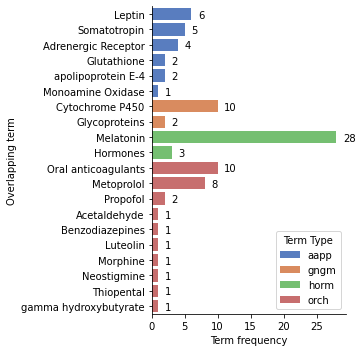

In [9]:
#remove Ethanol
lit_counts = lit_counts[lit_counts < 100]

#convert to df
lit_counts = lit_counts.reset_index(name='counts')

g = sns.catplot(
    y="st.name", 
    x="counts", 
    hue="st.type", 
    data=lit_counts, 
    height=5, 
    kind="bar", 
    palette="muted", 
    orient='horizontal',
    dodge=False,   
    legend=False
)
#add numbers to the bars
for i, v in enumerate(lit_counts['counts']):
    plt.text(v + 1, i + .25, str(v))
g.set(ylabel='Overlapping term', xlabel='Term frequency')
plt.legend(title='Term Type',loc='lower right')
plt.savefig('overlaps.png',dpi=1000)

## Look in detail at one overlapping term

Here we look at cases where `Leptin` is the central overlapping term.

In [10]:
focus_term = "Leptin"
lit_detail = lit_df_filter[lit_df_filter["st.name"] == focus_term]
lit_detail.head(n=10)

,gwas.trait,gwas.id,gs1.localCount,gs1.pval,s1.subject_name,s1.predicate,s1.id,s1.object_name,st.name,st.type,s2.subject_name,s2.predicate,s2.id,s2.object_name,gs2.localCount,gs2.pval,assoc_gwas.trait,assoc_gwas.id
481,Sleep duration,ieu-a-1088,5,1.767848e-12,ghrelin,INHIBITS,ghrelin:INHIBITS:Leptin,Leptin,Leptin,aapp,Leptin,TREATS,Leptin:TREATS:Coronary Arteriosclerosis,Coronary Arteriosclerosis,3,0.000083,Coronary heart disease,ieu-a-6
483,Sleep duration,ieu-a-1088,5,1.767848e-12,ghrelin,INHIBITS,ghrelin:INHIBITS:Leptin,Leptin,Leptin,aapp,Leptin,PREDISPOSES,Leptin:PREDISPOSES:Coronary heart disease,Coronary heart disease,2,0.001557,Coronary heart disease,ieu-a-6
485,Sleep duration,ieu-a-1088,5,1.767848e-12,ghrelin,INHIBITS,ghrelin:INHIBITS:Leptin,Leptin,Leptin,aapp,Leptin,INTERACTS_WITH,Leptin:INTERACTS_WITH:Proteome,Proteome,2,0.001557,Coronary heart disease,ieu-a-6
490,Sleep duration,ieu-a-1088,5,1.767848e-12,ghrelin,INHIBITS,ghrelin:INHIBITS:Leptin,Leptin,Leptin,aapp,Leptin,TREATS,"Leptin:TREATS:Sleep Apnea, Obstructive","Sleep Apnea, Obstructive",2,0.049402,Coronary heart disease,ieu-a-6
491,Sleep duration,ieu-a-1088,5,1.767848e-12,ghrelin,INHIBITS,ghrelin:INHIBITS:Leptin,Leptin,Leptin,aapp,Leptin,STIMULATES,Leptin:STIMULATES:Adiponectin,Adiponectin,2,0.066623,Coronary heart disease,ieu-a-6
492,Sleep duration,ieu-a-1088,5,1.767848e-12,ghrelin,INHIBITS,ghrelin:INHIBITS:Leptin,Leptin,Leptin,aapp,Leptin,INTERACTS_WITH,Leptin:INTERACTS_WITH:Insulin,Insulin,2,0.071198,Coronary heart disease,ieu-a-6


We can create a network diagram to visualise these relationships.

/Users/be15516/anaconda3/envs/epigraphdb-case-study/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


         gwas.trait     gwas.id  gs1.localCount      gs1.pval s1.subject_name  \
481  SLEEP DURATION  ieu-a-1088               5  1.767848e-12         ghrelin   
483  SLEEP DURATION  ieu-a-1088               5  1.767848e-12         ghrelin   
485  SLEEP DURATION  ieu-a-1088               5  1.767848e-12         ghrelin   
490  SLEEP DURATION  ieu-a-1088               5  1.767848e-12         ghrelin   
491  SLEEP DURATION  ieu-a-1088               5  1.767848e-12         ghrelin   

    s1.predicate                    s1.id s1.object_name st.name st.type  \
481     INHIBITS  ghrelin:INHIBITS:Leptin         Leptin  Leptin    aapp   
483     INHIBITS  ghrelin:INHIBITS:Leptin         Leptin  Leptin    aapp   
485     INHIBITS  ghrelin:INHIBITS:Leptin         Leptin  Leptin    aapp   
490     INHIBITS  ghrelin:INHIBITS:Leptin         Leptin  Leptin    aapp   
491     INHIBITS  ghrelin:INHIBITS:Leptin         Leptin  Leptin    aapp   

    s2.subject_name    s2.predicate  \
481          Lept

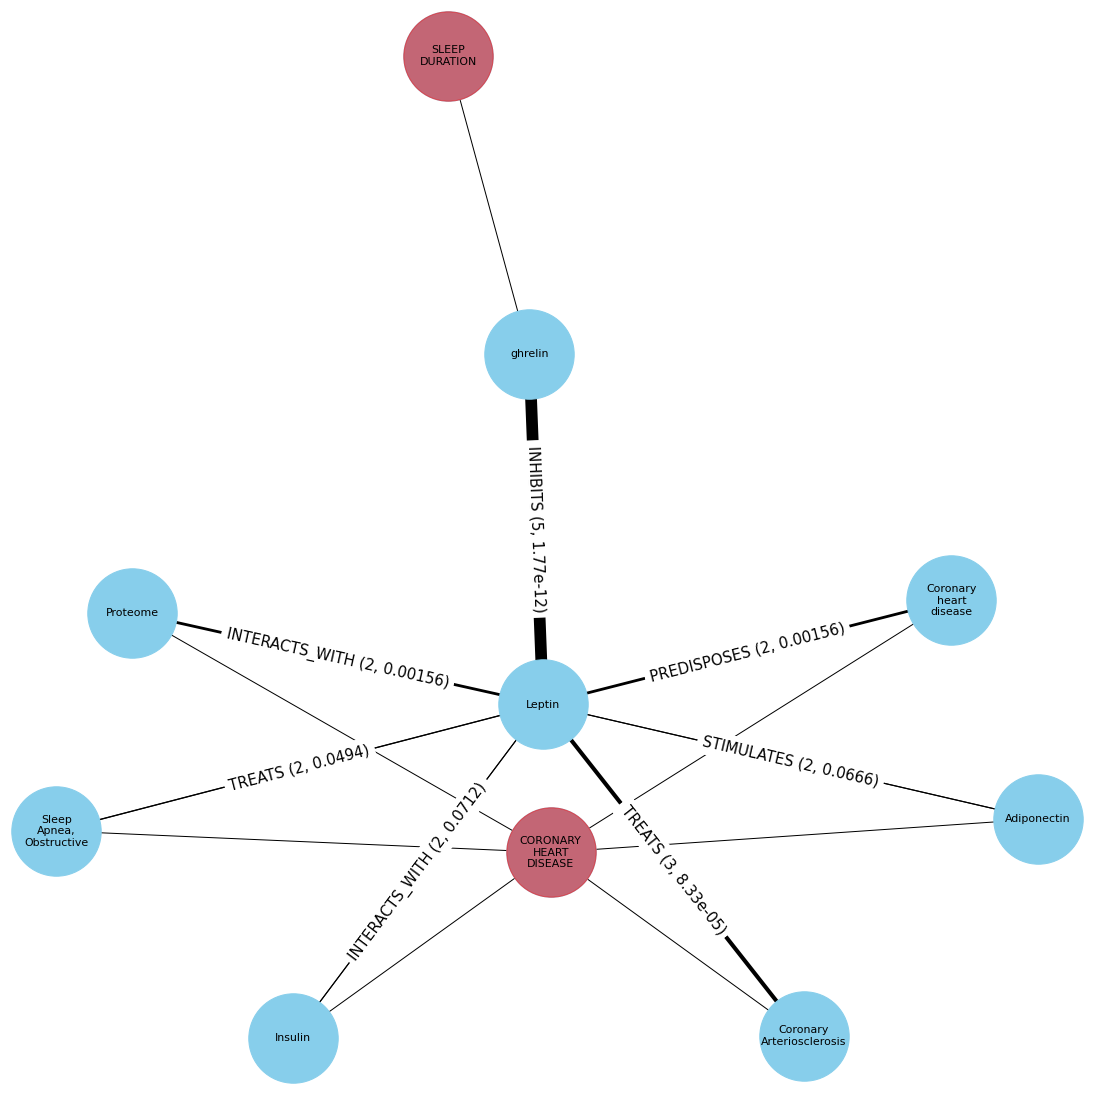

In [15]:
# set things up
exposure = "Sleep duration".upper()
outcome = "Coronary heart disease".upper()
lit_detail.loc[:, "gwas.trait"] = lit_detail["gwas.trait"].apply(
    lambda x: x.upper()
)
lit_detail.loc[:, "assoc_gwas.trait"] = lit_detail["assoc_gwas.trait"].apply(
    lambda x: x.upper()
)
print(lit_detail.head())
# create network data
d = []
d = lit_detail[["gwas.trait", "s1.subject_name"]].values.tolist()
d = d + lit_detail[["s2.object_name", "assoc_gwas.trait"]].values.tolist()
d = d + lit_detail[["s1.subject_name", "s1.object_name"]].values.tolist()
d = d + lit_detail[["s2.subject_name", "s2.object_name"]].values.tolist()


def add_newlines(text):
    text = text.replace(" ", "\n")
    return text


# add newlines to text to make them fit in the nodes! Got to be a better way to do this....
d_edit = []
for i in d:
    d_edit.append([add_newlines(x) for x in i])

# create the edge labels
labels = {}
for l in lit_detail[
    ["s1.subject_name", "s1.object_name", "s1.predicate", "gs1.localCount", "gs1.pval"]
].drop_duplicates().values.tolist():
    labels[(add_newlines(l[0]), add_newlines(l[1]))] = (
        add_newlines(l[2]) + " (" + str(l[3]) + ", "+str("{:.3g}".format(l[4]))+")"
    )
for l in lit_detail[
    ["s2.subject_name", "s2.object_name", "s2.predicate", "gs2.localCount", "gs2.pval"]
].drop_duplicates().values.tolist():
    labels[(add_newlines(l[0]), add_newlines(l[1]))] = (
        add_newlines(l[2]) + " (" + str(l[3]) + ", "+str("{:.3g}".format(l[4]))+")"
    )

# create the network
plt.figure(figsize=(15, 15))

G = nx.Graph(d_edit)

pos = graphviz_layout(G)

node_size = 8000

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_size,
    node_color="skyblue",
    font_size=11,
)

nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=15)

#add log10 pval as width 
for edge in labels:
    weight=float(labels[edge].split(' ')[-1].replace(')',''))
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=math.log10(weight)*-1)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=15)

# colour the GWAS nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=[add_newlines(exposure), add_newlines(outcome)],
    node_color="r",
    node_size=node_size,
    alpha=0.5,
)
# plt.show()
plt.savefig(focus_term + ".png")

## Checking the source literature

We can refer back to the articles to check the text that was used to derive the SemMedDB data. This is important due to the imperfect nature of the SemRep annotation process (https://semrep.nlm.nih.gov/). 

In [12]:
def get_literature(data):
    endpoint = "/literature/gwas"
    url = f"{API_URL}{endpoint}"
    params = {
        "gwas_id": data[0],
        "semmed_triple_id": data[1],
        "by_gwas_id": "true",
        "pval_threshold": 1e-1,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    df = pd.json_normalize(r.json()["results"])
    # print(df)
    return df[["triple.id", "lit.pubmed_id"]]


gwas_pub_df = lit_detail.drop_duplicates(["gwas.id", "s1.id"])[
    ["gwas.id", "s1.id"]
].apply(get_literature, axis=1)
assoc_gwas_pub_df = lit_detail.drop_duplicates(["assoc_gwas.id", "s2.id"])[
    ["assoc_gwas.id", "s2.id"]
].apply(get_literature, axis=1)

## Check the text

Do the data from SemMedDB match the literature origins? Here we can use the MELODI Presto API (http://melodi-presto.mrcieu.ac.uk/docs/) to examine the SemMedDB data in more detail.

In [13]:
def get_sentence_data(pmid):
    url = "https://melodi-presto.mrcieu.ac.uk/api/sentence/"
    params = {
        "pmid": pmid,
    }
    response = requests.post(url, data=json.dumps(params))
    res = response.json()
    df = pd.json_normalize(res)
    return df


def merge_semmed_with_pubmed(df_list):
    for i in df_list:
        pubmed_ids = i["lit.pubmed_id"].values
        triple_id = i["triple.id"].unique()
        print("\n###", triple_id, "###")
        for p in pubmed_ids:
            print("PMID:", p)
            sentence_data = get_sentence_data(p)
            for ss in sentence_data["data"]:
                for s in ss:
                    if s["SUB_PRED_OBJ"] == triple_id:
                        print("SENTENCE:", s["SENTENCE"])


merge_semmed_with_pubmed(gwas_pub_df)
merge_semmed_with_pubmed(assoc_gwas_pub_df)


### ['ghrelin:INHIBITS:Leptin'] ###
PMID: 21659802
SENTENCE: SUMMARY: Sleep is an important modulator of neuroendocrine function and glucose metabolism and sleep loss has been shown to result in metabolic and endocrine alterations, including decreased glucose tolerance, decreased insulin sensitivity, increased evening concentrations of cortisol, increased levels of ghrelin, decreased levels of leptin, and increased hunger and appetite.
PMID: 22473743
SENTENCE: On this basis, the present review examines the role of sleep curtailment in the metabolic and endocrine alterations, including decreased glucose tolerance and insulin sensitivity, increased evening concentrations of cortisol, increased levels of ghrelin, decreased levels of leptin and increased hunger and appetite.
PMID: 19955752
SENTENCE: The present chapter reviews epidemiologic studies in adults and children and laboratory studies in young adults indicating that sleep restriction results in metabolic and endocrine alterations